In [18]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import time
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool

import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")

##############

# My functions:
import vqe_functions as vqe
import qcnn_functions as qcnn


In [3]:
# Load data:

# Load data and separate in training and test set
data_noisy001 = joblib.load('./vqe_states_job/vqe_params_0.001noise.job')

train_index_noisy001 = np.sort(np.random.choice(np.arange(len(data_noisy001)), size=int(0.8*len(data_noisy001)), replace=False ))

X_train_noisy001, Y_train_noisy001 = [], []
X_test_noisy001, Y_test_noisy001   = [], []

for i in range(len(data_noisy001)): 
    if i in train_index_noisy001:
        X_train_noisy001.append(data_noisy001[i][0])
        Y_train_noisy001.append(data_noisy001[i][1])
    else:
        X_test_noisy001.append(data_noisy001[i][0])
        Y_test_noisy001.append(data_noisy001[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('NOISY DATA (p noise = 0.001):')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data_noisy001)))
print('Size of Training Set: {0}'.format(np.shape(X_train_noisy001)[0]))
print('Size of Test Set    : {0}\n'.format(np.shape(X_test_noisy001)[0]))

# Load data and separate in training and test set
data_noisy005 = joblib.load('./vqe_states_job/vqe_params_0.005noise.job')

train_index_noisy005 = np.sort(np.random.choice(np.arange(len(data_noisy005)), size=int(0.8*len(data_noisy005)), replace=False ))

X_train_noisy005, Y_train_noisy005 = [], []
X_test_noisy005, Y_test_noisy005   = [], []

for i in range(len(data_noisy005)): 
    if i in train_index_noisy005:
        X_train_noisy005.append(data_noisy005[i][0])
        Y_train_noisy005.append(data_noisy005[i][1])
    else:
        X_test_noisy005.append(data_noisy005[i][0])
        Y_test_noisy005.append(data_noisy005[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('NOISY DATA (p noise = 0.005):')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data_noisy005)))
print('Size of Training Set: {0}'.format(np.shape(X_train_noisy005)[0]))
print('Size of Test Set    : {0}\n'.format(np.shape(X_test_noisy005)[0]))


# Load data and separate in training and test set
data = joblib.load('./vqe_states_job/vqe_params_0noise.job')

train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))

X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('CLEAN DATA:')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data)))
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))

NOISY DATA (p noise = 0.001):
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20

NOISY DATA (p noise = 0.005):
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20

CLEAN DATA:
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20


In [7]:
N = 4
J = 1

In [8]:
dev_vqe_mixed   = qml.device("default.mixed", wires = N, shots = None)

In [31]:
@qml.qnode(dev_vqe_mixed)
def magnetization(vqe_params, N, shift_invariance, p_noise = 0, p_noise_ent = 0):
    vqe.circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # Interaction of spins with magnetic field
    M = qml.PauliZ(0)
    for i in range(1,N):
        M += qml.PauliZ(i)
    M = (1/N) * M
    # return <psi|M|psi>
    return qml.expval(M)

@qml.qnode(dev_vqe_mixed)
def energy(vqe_params, N, shift_invariance, mu, J, p_noise = 0, p_noise_ent = 0):
    vqe.circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # return <psi|H|psi>
    return qml.expval(vqe.qml_build_H(N, mu, J))

In [14]:
M = qml.PauliZ(0)
for i in range(1,N):
    M += qml.PauliZ(i)
M = (1/N) * M

mags = []
energies = []

for mu in np.linspace(0,2*J,100):
    H = vqe.qml_build_H(N,float(mu),J)
    Hmat = np.real( qml.matrix(H) )
    eigval, eigvec = np.linalg.eig(Hmat)
    
    gstate = eigvec[:,np.argmin(eigval)]
    
    mags.append( np.transpose(gstate) @ qml.matrix(M) @ gstate )
    energies.append( np.transpose(gstate) @ Hmat @ gstate )

In [49]:
mags_circuit_0noise = []
enes_circuit_0noise = []
for i, state in enumerate(data):
    mags_circuit_0noise.append(magnetization(state[0], N, 0) )
    enes_circuit_0noise.append(energy(state[0], N, 0, float(2*i/J), J) )
    
mags_circuit_001noise = []
enes_circuit_001noise = []
for i, state in enumerate(data_noisy001):
    mags_circuit_001noise.append(magnetization(state[0], N, 0) )
    enes_circuit_001noise.append(energy(state[0], N, 0, float(2*i/J), J) )
    
mags_circuit_005noise = []
enes_circuit_005noise = []
for i, state in enumerate(data_noisy005):
    mags_circuit_005noise.append(magnetization(state[0], N, 0) )
    enes_circuit_005noise.append(energy(state[0], N, 0, float(2*i/J), J) )

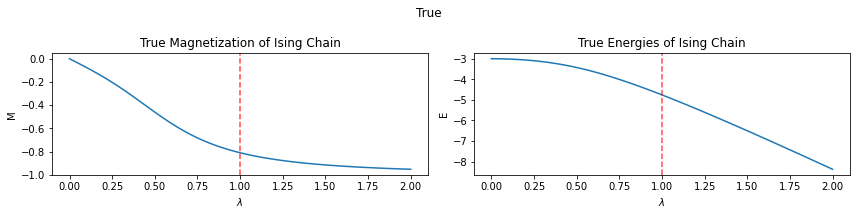

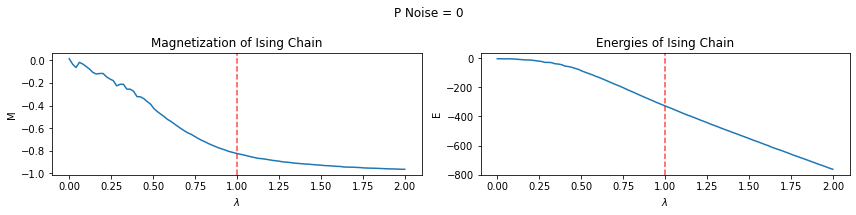

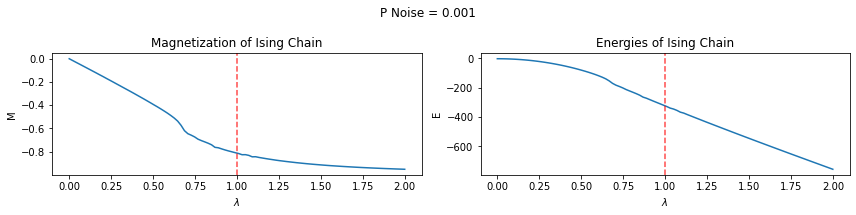

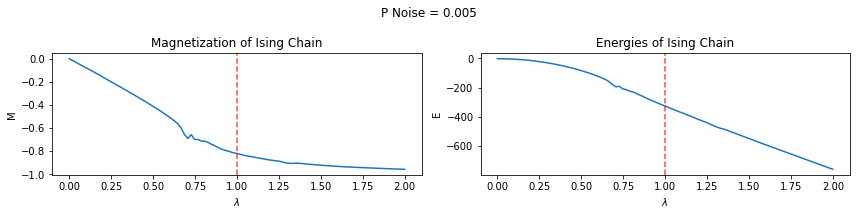

In [67]:
x = np.linspace(0,2*J,100)

fig, ax = plt.subplots(1, 2, figsize=(12,3))
fig.suptitle('True')
ax[0].plot(x, np.real(mags) )
ax[0].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[0].set_title('True Magnetization of Ising Chain')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('M')
ax[1].plot(x, np.real(energies) )
ax[1].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[1].set_title('True Energies of Ising Chain')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel('E')
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(12,3))
fig.suptitle('P Noise = 0')
ax[0].plot(x, mags_circuit_0noise )
ax[0].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[0].set_title('Magnetization of Ising Chain')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('M')
ax[1].plot(x, enes_circuit_0noise )
ax[1].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[1].set_title('Energies of Ising Chain')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel('E')
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(12,3))
fig.suptitle('P Noise = 0.001')
ax[0].plot(x, mags_circuit_001noise )
ax[0].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[0].set_title('Magnetization of Ising Chain')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('M')
ax[1].plot(x, enes_circuit_001noise )
ax[1].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[1].set_title('Energies of Ising Chain')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel('E')
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(12,3))
fig.suptitle('P Noise = 0.005')
ax[0].plot(x, mags_circuit_005noise )
ax[0].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[0].set_title('Magnetization of Ising Chain')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('M')
ax[1].plot(x, enes_circuit_005noise )
ax[1].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[1].set_title('Energies of Ising Chain')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel('E')
plt.tight_layout()

In [102]:
N = 4
M = qml.PauliZ(0)
for i in range(1,N):
    M += qml.PauliZ(i)
M = (1/N) * M

jmags = []

for j in np.linspace(1,5,100):
    H = vqe.qml_build_H(N,float(j),float(j) )
    Hmat = np.real( qml.matrix(H) )
    eigval, eigvec = np.linalg.eig(Hmat)
    
    gstate = eigvec[:,np.argmin(eigval)]
    
    jmags.append( np.transpose(gstate) @ qml.matrix(M) @ gstate )
    

(0.0, -1.0)

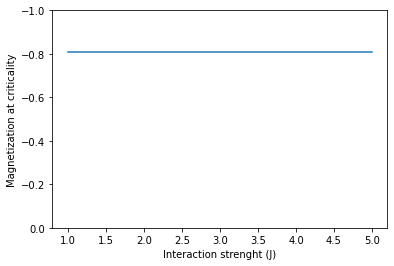

In [104]:
plt.plot(np.linspace(1,5,100), jmags)
plt.xlabel('Interaction strenght (J)')
plt.ylabel('Magnetization at criticality')
plt.ylim(0,-1)

In [98]:
nmags = []
J = 1
for n in range(2,12):
    M = qml.PauliZ(0)
    for i in range(1,n):
        M += qml.PauliZ(i)
    M = (1/n) * M
    
    H = vqe.qml_build_H(n,float(J),float(J) )
    Hmat = np.real( qml.matrix(H) )
    eigval, eigvec = np.linalg.eig(Hmat)

    gstate = eigvec[:,np.argmin(eigval)]

    nmags.append( np.transpose(gstate) @ qml.matrix(M) @ gstate )
    

Text(0.5, 0, 'Number of spins (N)')

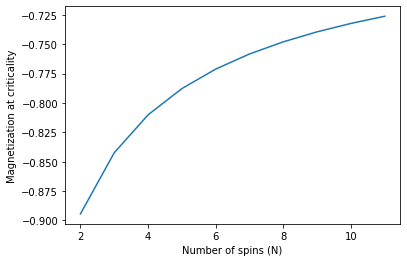

In [105]:
plt.plot(range(2,12),nmags)
plt.ylabel('Magnetization at criticality')
plt.xlabel('Number of spins (N)')

In [20]:
@qml.qnode(dev_vqe_mixed)
def qcnn_circ(params, N, vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0):
    '''
    Building function for the circuit:
          VQE(params_vqe) + QCNN(params)
    '''
        
    # Wires that are not measures (through pooling)
    active_wires = np.arange(N)
    
    
    # Index of the parameter vector
    p_index = 0
    
    while(len(active_wires) > 1):
        p_index = qcnn.qcnn_convolution(active_wires, params, N, p_index, conv_noise = qcnn_conv_noise)
        qml.Barrier()
        p_index, active_wires = qcnn.qcnn_pooling(active_wires, params, N, p_index, pool_noise = qcnn_pool_noise)
        qml.Barrier()
    
    # Final Y rotation
    qml.RY(params[p_index], wires = N-1)
    if qcnn_pool_noise > 0: qml.PhaseFlip(qcnn_pool_noise, wires = N - 1 ); qml.BitFlip(qcnn_pool_noise, wires = N - 1 )
    
    return qml.probs(wires = N - 1)

In [24]:
N = 6

In [25]:
drawer = qml.draw(qcnn_circ)
print(drawer([0]*100, N))

0: ──RX(0.00)──RY(0.00)─╭C──RX(0.00)───────────────||─╭C────────────────────────
1: ──RX(0.00)──RY(0.00)─╰X───────────╭C──RX(0.00)──||─╰ControlledOperation(0.00)
2: ──RX(0.00)──RY(0.00)─╭C──RX(0.00)─╰X────────────||─╭C────────────────────────
3: ──RX(0.00)──RY(0.00)─╰X───────────╭C──RX(0.00)──||─╰ControlledOperation(0.00)
4: ──RX(0.00)──RY(0.00)─╭C──RX(0.00)─╰X────────────||─╭C────────────────────────
5: ──RX(0.00)──RY(0.00)─╰X──RX(0.00)───────────────||─╰ControlledOperation(0.00)

──╭C──────────────────────────||─────────────────────────────────────────────||
──╰ControlledOperation(0.00)──||──RX(0.00)──RY(0.00)─╭C──RX(0.00)────────────||
──╭C──────────────────────────||─────────────────────│───────────────────────||
──╰ControlledOperation(0.00)──||──RX(0.00)──RY(0.00)─╰X─╭C─────────RX(0.00)──||
──╭C──────────────────────────||────────────────────────│────────────────────||
──╰ControlledOperation(0.00)──||──RX(0.00)──RY(0.00)────╰X─────────RX(0.00)──||

────────────────────────────────